In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from pathlib import Path

import shamans.utils.eval_utils as eval

In [5]:
ang_error_threshold_choices = [15]

In [6]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False, encoding='utf-8-sig')
    return combined_csv

In [7]:
# load data
exp_id = 6
path_to_results = Path('results/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)
exp_df = exp_df.assign(sv_model=exp_df['sv_method'] + '_' + exp_df['nObs'].astype(str))
exp_df['sv_model'] = exp_df['sv_model'].str.replace('ref_8', 'ref')
exp_df['sv_model'] = exp_df['sv_model'].str.replace('alg_8', 'alg')

In [8]:
print(exp_df['seed'].unique())
print(exp_df['noise_type'].unique())
print(exp_df['n_sources'].unique())
print(exp_df['snr'].unique())
print(exp_df['duration'].unique())
print(exp_df['rt60'].unique())
print(exp_df['loc_method'].unique())
print(exp_df['sv_model'].unique())

[ 13 666]
['awgn']
[4 7]
[20]
[1.]
[0.    0.123 0.273]
['music_s-1' 'music_s-5' 'alpha-1.2_beta-1_eps-1E-3_iter-500' 'srp_phat'
 'alpha-X.X_beta-1_eps-1E-3_iter-500' 'alpha-2.0_beta-1_eps-1E-3_iter-500'
 'music_s-6']
['ref' 'alg' 'gp-steerer_8' 'gp-steerer_16' 'gp-steerer_32'
 'gp-steerer_64' 'gp-steerer_128']


In [9]:
# filter out some data
exp_df = exp_df[
    (exp_df['n_sources'] > 3) & 
    # (exp_df['rt60'] == 0.123) &
    (exp_df['loc_method'].isin(
        ['srp_phat',
        'music_s-1',
        'music_s-4',
        'alpha-1.2_beta-1_eps-1E-3_iter-500',
        'alpha-X.X_beta-1_eps-1E-3_iter-500',
        'alpha-2.0_beta-1_eps-1E-3_iter-500',
        ]))
]

In [10]:
# compute accuracy and recall for each doas estimated by each method within a threshold of 10 degrees
def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

exp_df['ang_error'] = calc_ae(
    np.rad2deg(exp_df['doas_est_az']), 
    np.rad2deg(exp_df['doas_ref_az'])
)

# compute accuracy and recall based on the frame id as in DCASE Task 3
unique_frame_ids = exp_df['frame_id'].unique()
unique_method_ids = exp_df['method_id'].unique()

df_thresholds = pd.DataFrame()

for frame_id in tqdm(unique_frame_ids, desc='frame'):
    df_frame = exp_df[exp_df['frame_id'] == frame_id]
    
    for method_id in unique_method_ids:
        df_method = df_frame[df_frame['method_id'] == method_id]    
                
        assert len(df_method) == np.unique(df_method['doas_est_az']).shape[0] == np.unique(df_method['n_sources'])
            
        # accuracy and mean error
        for thr in ang_error_threshold_choices:
            
            accuracy = np.sum(df_method['ang_error'] <= thr) / len(df_method)
            error = np.mean(df_method[df_method['ang_error'] <= thr]['ang_error'])

            df_ = pd.DataFrame({
                "frame_id": frame_id,
                "method_id": method_id,
                "accuracy": accuracy,
                "mean_error": error,
                "threshold": thr
            }, index=[0])
            df_thresholds = pd.concat([df_thresholds, df_], ignore_index=True)

frame: 100%|██████████| 120/120 [00:02<00:00, 43.28it/s]


In [11]:
df_merge = exp_df.merge(df_thresholds, on=['frame_id', 'method_id'])

In [12]:
df_merge = df_merge.assign(sv_model=df_merge['sv_method'] + '_' + df_merge['nObs'].astype(str))
df_merge = df_merge.assign(loc_algo=df_merge['loc_method'].str[:3])

print(df_merge['sv_method'].unique())
print(df_merge['sv_model'].unique())
print(df_merge['noise_type'].unique())
print(df_merge['n_sources'].unique())
print(df_merge['snr'].unique())
print(df_merge['duration'].unique())
print(df_merge['rt60'].unique())
print(df_merge['loc_method'].unique())

['ref' 'alg' 'gp-steerer']
['ref_8' 'alg_8' 'gp-steerer_8' 'gp-steerer_16' 'gp-steerer_32'
 'gp-steerer_64' 'gp-steerer_128']
['awgn']
[4 7]
[20]
[1.]
[0.    0.123 0.273]
['music_s-1' 'alpha-1.2_beta-1_eps-1E-3_iter-500' 'srp_phat'
 'alpha-X.X_beta-1_eps-1E-3_iter-500' 'alpha-2.0_beta-1_eps-1E-3_iter-500']


In [13]:
best_seed = 666
# rename ref_8 and alg_6 to ref and alg
df_merge['sv_model'] = df_merge['sv_model'].str.replace('ref_8', 'ref')
df_merge['sv_model'] = df_merge['sv_model'].str.replace('alg_8', 'alg')
df_merge.loc[df_merge['sv_model'] == 'ref', 'seed'] = 666
df_merge.loc[df_merge['sv_model'] == 'alg', 'seed'] = 666

In [14]:
nice_plot_df = df_merge.copy()

nice_plot_df.loc[nice_plot_df['loc_method'] == 'srp_phat', 'loc_method'] = 'SRP-PHAT'
for nSrc in [1, 2, 4, 5, 6]:
    nice_plot_df.loc[nice_plot_df['loc_method'] == f'music_s-{nSrc}', 'loc_method'] = f'MUSIC-{nSrc}'
nice_plot_df.loc[nice_plot_df['loc_method'] == 'alpha-1.2_beta-1_eps-1E-3_iter-500', 'loc_method'] = 'ALPHA-1.2_BETA-1'
nice_plot_df.loc[nice_plot_df['loc_method'] == 'alpha-2.0_beta-1_eps-1E-3_iter-500', 'loc_method'] = 'ALPHA-2.0_BETA-1'
nice_plot_df.loc[nice_plot_df['loc_method'] == 'alpha-X.X_beta-1_eps-1E-3_iter-500', 'loc_method'] = 'ALPHA-EST_BETA-1'

nice_plot_df.loc[nice_plot_df['sv_model'] == 'ref', 'sv_model'] = 'REF'
nice_plot_df.loc[nice_plot_df['sv_model'] == 'alg', 'sv_model'] = 'ALG'
for nObs in [8, 16, 32, 64, 128]:
    nice_plot_df.loc[nice_plot_df['sv_model'] == f'gp-steerer_{nObs}', 'sv_model'] = f'NS-{nObs}'

algo_order = ['SRP-PHAT', 'MUSIC-1', 'ALPHA-1.2_BETA-1', 'ALPHA-2.0_BETA-1', 'ALPHA-EST_BETA-1']
n_algos = len(algo_order)
print(nice_plot_df['sv_model'].unique())
print(nice_plot_df['n_sources'].unique())
print(nice_plot_df['loc_method'].unique())


['REF' 'ALG' 'NS-8' 'NS-16' 'NS-32' 'NS-64' 'NS-128']
[4 7]
['MUSIC-1' 'ALPHA-1.2_BETA-1' 'SRP-PHAT' 'ALPHA-EST_BETA-1'
 'ALPHA-2.0_BETA-1']


In [15]:
num_max_sources = np.unique(nice_plot_df['n_sources'])
loc_methods = np.unique(nice_plot_df['loc_method'])
sv_methods = np.unique(nice_plot_df['sv_method'])
rt60_choices = np.unique(nice_plot_df['rt60'])
thresholds = np.unique(nice_plot_df['threshold'])

print(thresholds)

[15]


['MUSIC' 'ALPHA' 'SRP']
rt60: 0.0


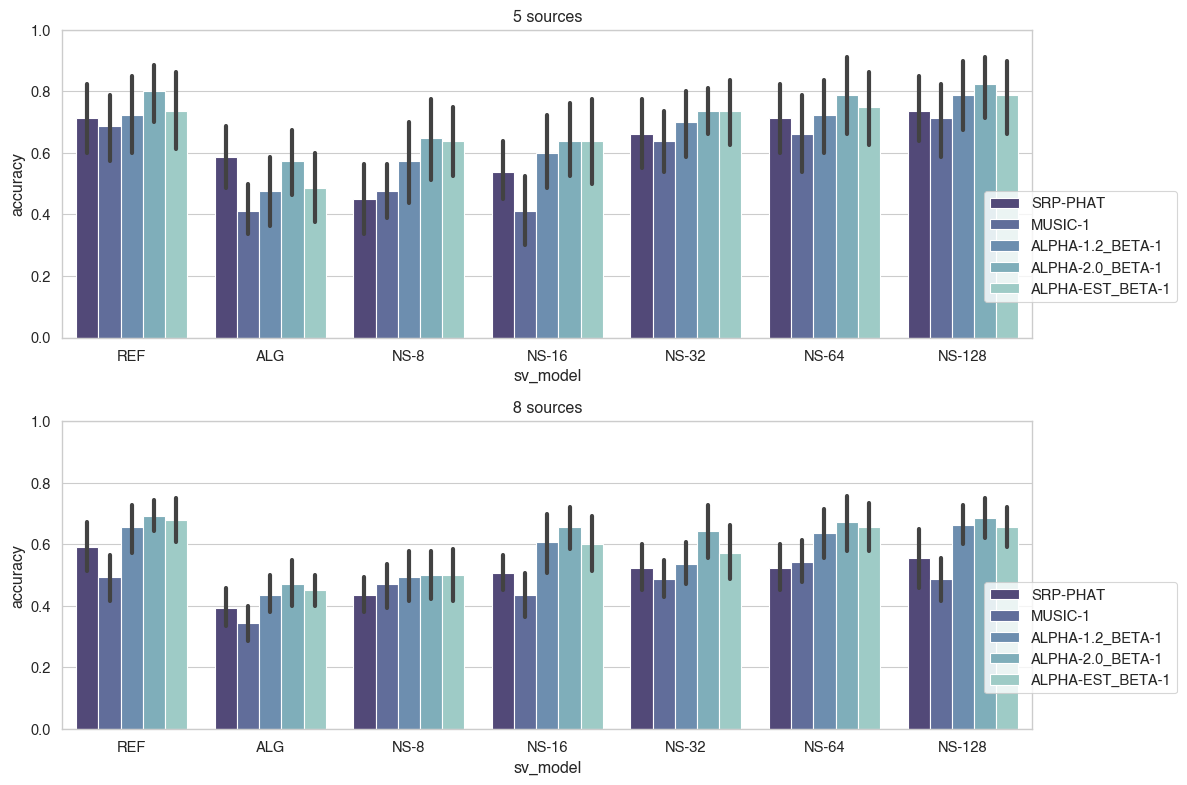

rt60: 0.123


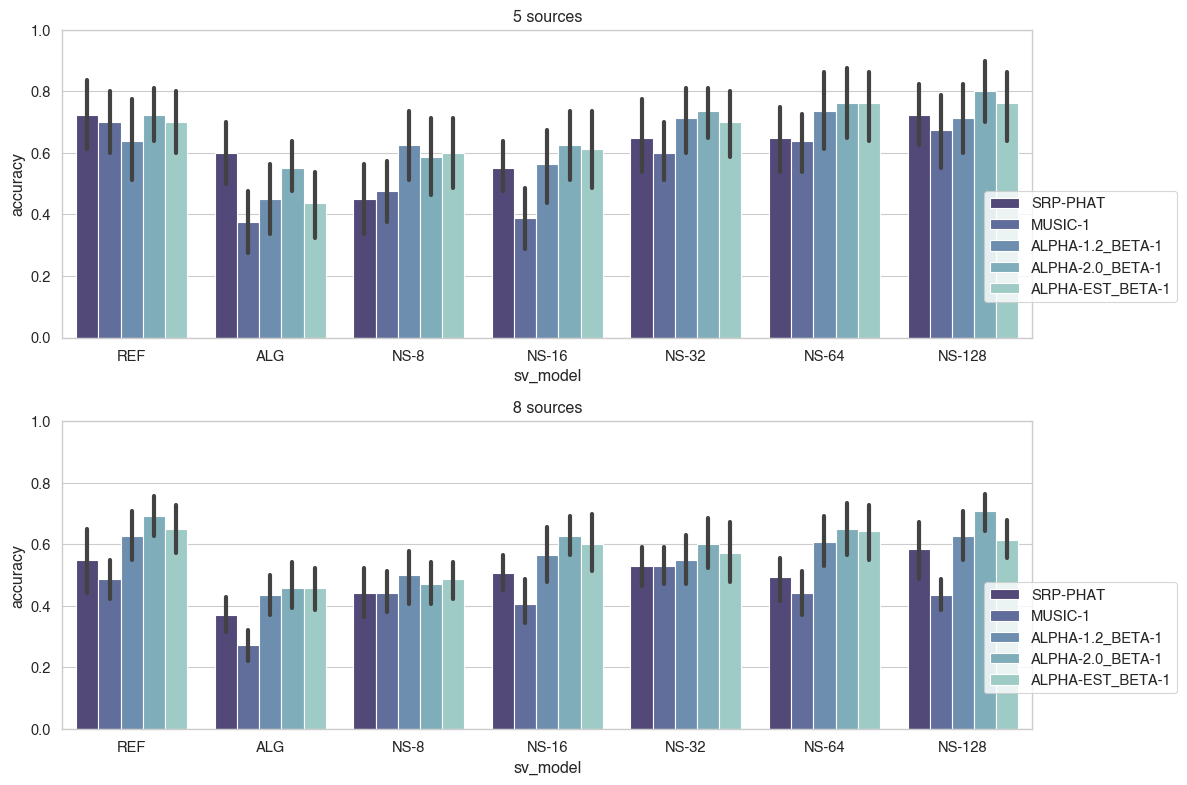

rt60: 0.273


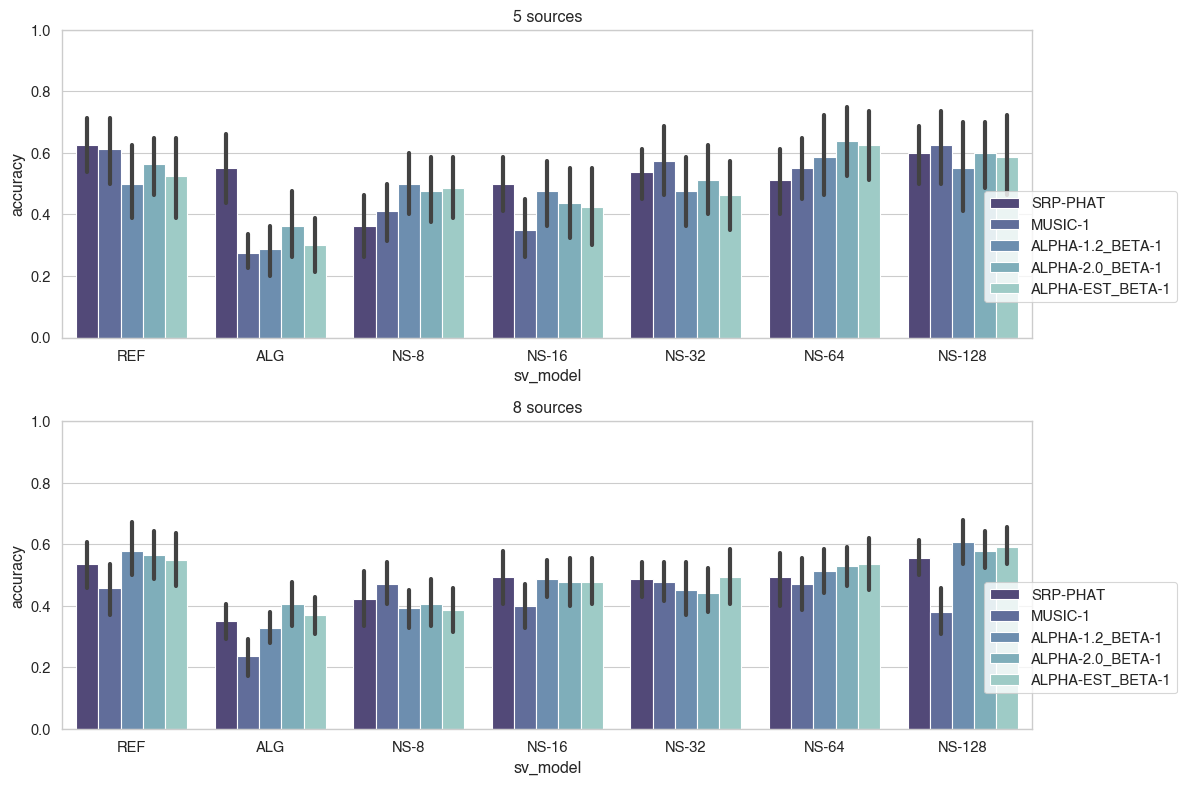

In [16]:
nice_plot_df['loc_method_simple'] = nice_plot_df['loc_method'].apply(lambda x: x.split('-')[0])

print(nice_plot_df['loc_method_simple'].unique())

sns.set(style='whitegrid', context='paper', font_scale=1.2,
        rc={
            'figure.figsize':(3.5,3.15), 
            'lines.linewidth':2.,
            'font.family': 'sans-serif',
            'font.sans-serif': [u'Helvetica'],
            'text.usetex': False,
            })
pal = sns.cubehelix_palette(n_algos, start=0.5, rot=-0.5,dark=0.3, light=.75, reverse=True, hue=1.)
sns.set_palette(pal)


for rt60 in rt60_choices:
    print(f'rt60: {rt60}')
    
    fig, axarr = plt.subplots(len(num_max_sources), 1, figsize=(12, 8))
    for i, n_sources in enumerate(num_max_sources):

        df_ = nice_plot_df[
            (nice_plot_df['seed'] == best_seed)
            & (nice_plot_df['record_id'] == 's0')
            & (nice_plot_df['n_sources'] == n_sources)
            & (nice_plot_df['rt60'] == rt60)
        ]
            
        ax = sns.barplot(
            data=df_,
            x='sv_model',
            y='accuracy',
            hue='loc_method',
            hue_order=algo_order,
            ax=axarr[i],
        )
        ax.set_ylim([0, 1])
        # place legend above plot
        axarr[i].legend(loc='upper center', bbox_to_anchor=(1.05, 0.5), ncol=1)
        axarr[i].set_title(f'{n_sources+1} sources')
    plt.tight_layout()
    plt.show()

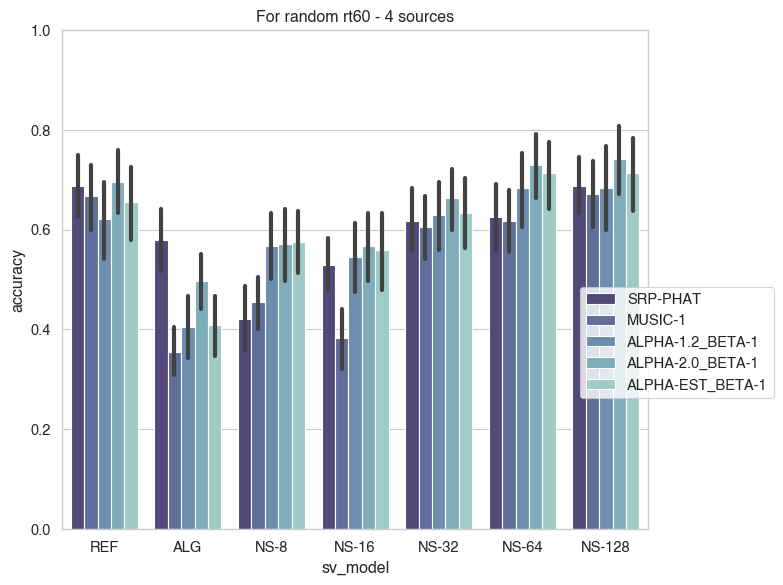

In [17]:
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
n_sources = 4
df_ = nice_plot_df[
    (nice_plot_df['seed'] == best_seed)
    & (nice_plot_df['record_id'] == 's0')
    & (nice_plot_df['n_sources'] == n_sources)
]
    
ax = sns.barplot(
    data=df_,
    x='sv_model',
    y='accuracy',
    hue='loc_method',
    hue_order=algo_order,
    ax=axarr,
)
ax.set_ylim([0, 1])
# place legend above plot
axarr.legend(loc='upper center', bbox_to_anchor=(1.05, 0.5), ncol=1)
axarr.set_title(f'For random rt60 - {n_sources} sources')
plt.tight_layout()
plt.show()

['MUSIC' 'ALPHA' 'SRP']
rt60: 0.0


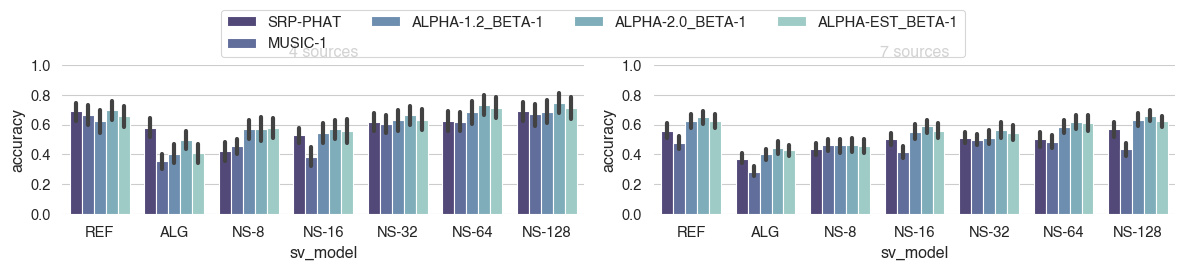

rt60: 0.123


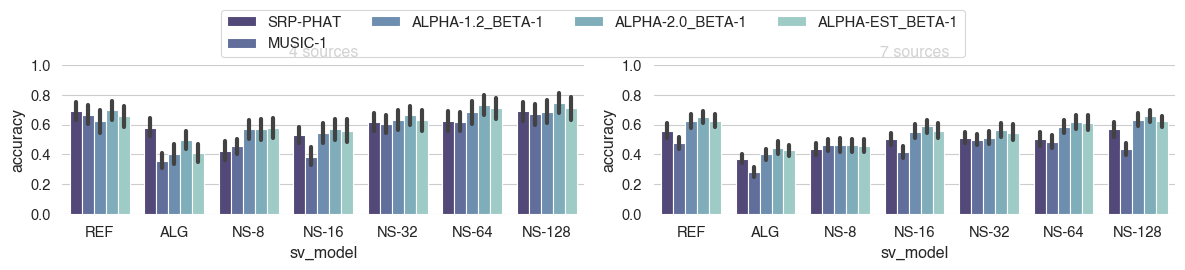

rt60: 0.273


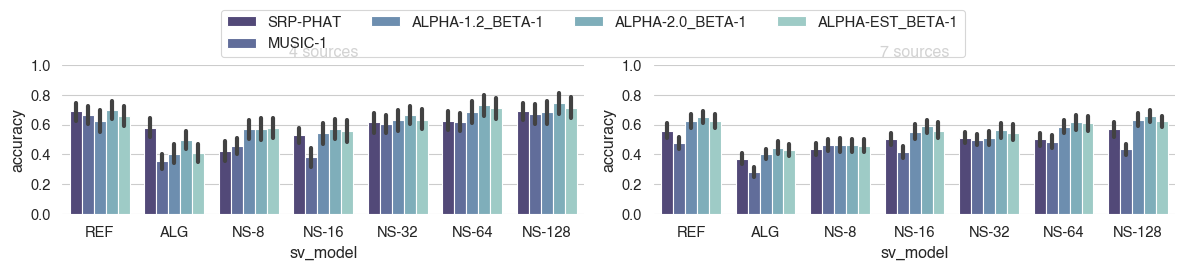

In [18]:
nice_plot_df['loc_method_simple'] = nice_plot_df['loc_method'].apply(lambda x: x.split('-')[0])

print(nice_plot_df['loc_method_simple'].unique())

sns.set(style='whitegrid', context='paper', font_scale=1.2,
        rc={
            'figure.figsize':(3.5,3.15), 
            'lines.linewidth':2.,
            'font.family': 'sans-serif',
            'font.sans-serif': [u'Helvetica'],
            'text.usetex': False,
            })
pal = sns.cubehelix_palette(n_algos, start=0.5, rot=-0.5,dark=0.3, light=.75, reverse=True, hue=1.)
sns.set_palette(pal)


for rt60 in rt60_choices:
    print(f'rt60: {rt60}')
    
    fig, axarr = plt.subplots(1, len(num_max_sources), figsize=(12, 2.5))
    
    for i, n_sources in enumerate(num_max_sources):

        df_ = nice_plot_df[
            (nice_plot_df['seed'] == best_seed)
            & (nice_plot_df['record_id'] == 's0')
            & (nice_plot_df['n_sources'] == n_sources)
        ]
            
        ax = sns.barplot(
            data=df_,
            x='sv_model',
            y='accuracy',
            hue='loc_method',
            hue_order=algo_order,
            ax=axarr[i],
        )
        # hide the legend
        ax.get_legend().remove()
        ax.set_ylim([0, 1])
        # place legend above plot
        ax.set_title(f'{n_sources} sources')
        
        # axarr[i].legend(loc='upper center', bbox_to_anchor=(1.5, 0.5), ncol=1)
        # axarr[i].set_title(f'{n_sources} sources')
        
        # remove spine
        sns.despine(offset=10, trim=False, left=True, bottom=True, ax=ax)
        
    # add a common legend for all subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4)
    
    plt.savefig(f'./eusipco2025_exp-{exp_id}_rt60-{rt60}_accuracy.pdf', bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()